In [1]:
# Import libraries
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Unzipping train.zip
with zipfile.ZipFile("/kaggle/input/dogs-vs-cats/train.zip", 'r') as zip_ref:
    zip_ref.extractall("/kaggle/working/train")

train_path = "/kaggle/working/train/train"

2025-06-18 10:46:34.982530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750243595.182997      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750243595.241409      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Organize data into separate folders for ImageDataGenerator
import shutil

# Create new directory structure
base_dir = "/kaggle/working/dataset"
os.makedirs(base_dir, exist_ok=True)
os.makedirs(base_dir + '/train/cats', exist_ok=True)
os.makedirs(base_dir + '/train/dogs', exist_ok=True)

# Split files into cats and dogs folders
for file in os.listdir(train_path):
    if "cat" in file:
        shutil.move(os.path.join(train_path, file), base_dir + '/train/cats/' + file)
    else:
        shutil.move(os.path.join(train_path, file), base_dir + '/train/dogs/' + file)

In [3]:
# Prepare the data generators

IMG_SIZE = 224
BATCH_SIZE = 32

# Data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    base_dir + '/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    base_dir + '/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [4]:
# Build ResNet50 model

# Load pre-trained ResNet50 without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # freeze base model

model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

I0000 00:00:1750243622.256340      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750243622.257088      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,433,025 (138.98 MB)

 Trainable params: 12,845,313 (49.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [5]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

# Fine-tuning (Optional)

# Unfreeze some layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1750243636.596320      77 service.cc:148] XLA service 0x7c04e0001510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750243636.597318      77 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750243636.597345      77 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750243638.198598      77 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/625 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.6406 - loss: 2.3939   

I0000 00:00:1750243643.581037      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 92s 118ms/step - accuracy: 0.5559 - loss: 1.1774 - val_accuracy: 0.6334 - val_loss: 0.6540
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 72s 114ms/step - accuracy: 0.5997 - loss: 0.6635 - val_accuracy: 0.6312 - val_loss: 0.6554
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 71s 113ms/step - accuracy: 0.6196 - loss: 0.6515 - val_accuracy: 0.5318 - val_loss: 0.6898
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 71s 113ms/step - accuracy: 0.6138 - loss: 0.6514 - val_accuracy: 0.6678 - val_loss: 0.6231
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 71s 113ms/step - accuracy: 0.6236 - loss: 0.6407 - val_accuracy: 0.6704 - val_loss: 0.6087
Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 116s 151ms/step - accuracy: 0.6612 - loss: 0.6241 - val_accuracy: 0.7192 - val_loss: 0.5425
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 89s 142ms/step - accuracy: 0.7569 - loss: 0.5089 - val_accuracy: 0.7668 - val_loss: 0.4878
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 88s 141ms/step - accuracy: 0.7829 - loss: 0.4562 - val_accur

In [6]:
# Evaluate model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"\nValidation Accuracy: {val_accuracy*100:.2f}%")

157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.7125 - loss: 0.5745

Validation Accuracy: 71.52%


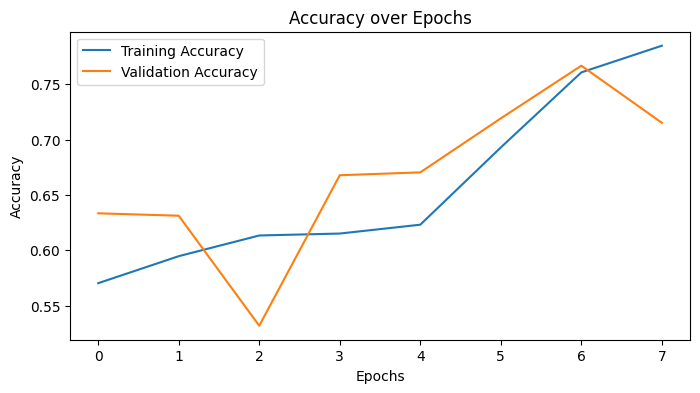

In [7]:
# Plotting training results
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()